In [1]:
from matplotlib import pyplot as plt
from PIL import Image

import sys
import os
sys.path.insert(0, "../packages/python")
from data import utils as data_utils
from data import augmentation as data_augmentation

# Data Handling Examples

This notebook presents a series of functions used to create and operate on datasets.
It is not intended to perform any operation in particular, it just serve as a reference for how to chain operations.

In [2]:
# Location of the raw images data, modify to your own structure.
IMAGES_FOLDER = "../untracked/datasets/Abril2023/uploaded"
# Location of the generated dataset, leave blanc ("") if you do not desire to save the data.
OUTPUT_FOLDER = "../untracked/datasets/Abril2023/raw_dataset"

# Annotation file for the images in the IMAGES_FOLDER (COCO format)
ANNOTATION_FILE = "corte-21-04-2024.json" 
ANNOTATION_FILE = os.path.join("../untracked/datasets/Abril2023/", ANNOTATION_FILE)

### Create basic dataset

This will process the input images using the annotations and produce a dataset containin only the annotated images

In [3]:
images, masks, metadata = data_utils.process_dataset_annotations(IMAGES_FOLDER, ANNOTATION_FILE, OUTPUT_FOLDER)

Deleting output path.
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Found 58 annotations


100%|██████████| 58/58 [00:24<00:00,  2.40it/s]


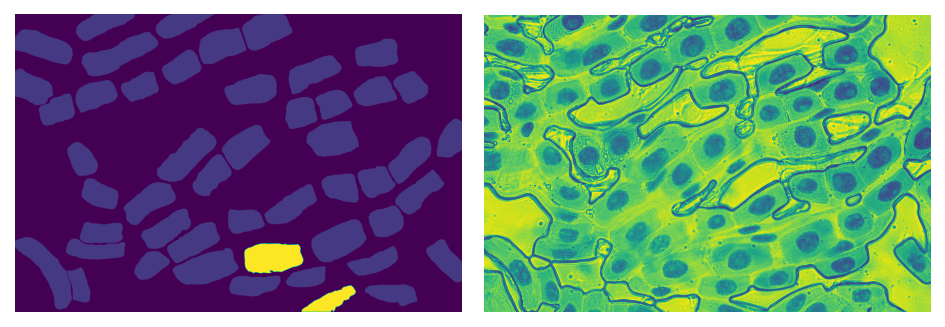

In [4]:
# Present an image from the dataset

# Choose one
sample_show = 22 
# Get data 
image_use = Image.fromarray(images[sample_show, :, :, 0])
mask_use = Image.fromarray(masks[sample_show, :, :, 0])

# Plot
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(mask_use)
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(image_use)
plt.axis("off")
plt.tight_layout()
plt.show()


In [5]:
# A convenient function to get the files in a folder, will show the dataset files ordered in a dictionary
if OUTPUT_FOLDER != "":
    files_dict = data_utils.find_files(OUTPUT_FOLDER, "png")
    print(list(files_dict.keys()))
    print(files_dict["path"][0], files_dict["target"][0], files_dict["input"][0])

['path', 'target', 'input']
. ../untracked/datasets/Abril2023/raw_dataset/target/331.png ../untracked/datasets/Abril2023/raw_dataset/input/331.png


### Apply Basic Augmentation

One of the simplest augmentation process is to modify an image in terms of brightness, contrast, saturation and flip.

NOTE: This process is aplied to a single image.

In [6]:
image_changed, mask_use_changed = data_augmentation.change_image_basic(image_use, mask_use)

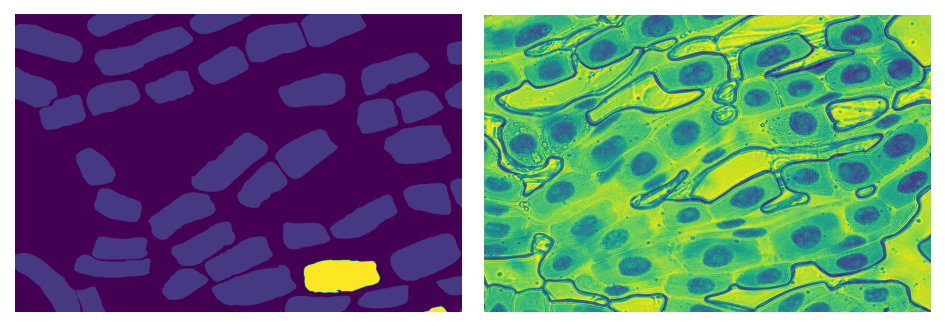

In [7]:
# Plot
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(mask_use_changed)
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(image_changed)
plt.axis("off")
plt.tight_layout()
plt.show()

### Crop Dataset into Centred Cells

Here we take the raw dataset and generate a new dataset with smaller images were each image cointains a centered cell.

In [8]:
cell_images, cell_masks = data_utils.centred_cells_dataset(images, masks, 512, blur_kernel = (5, 5), threshold_sigma=2, verbose=False)
print(f"Number of cells detected and cropped: {len(cell_images)}")

Number of cells detected and cropped: 1917


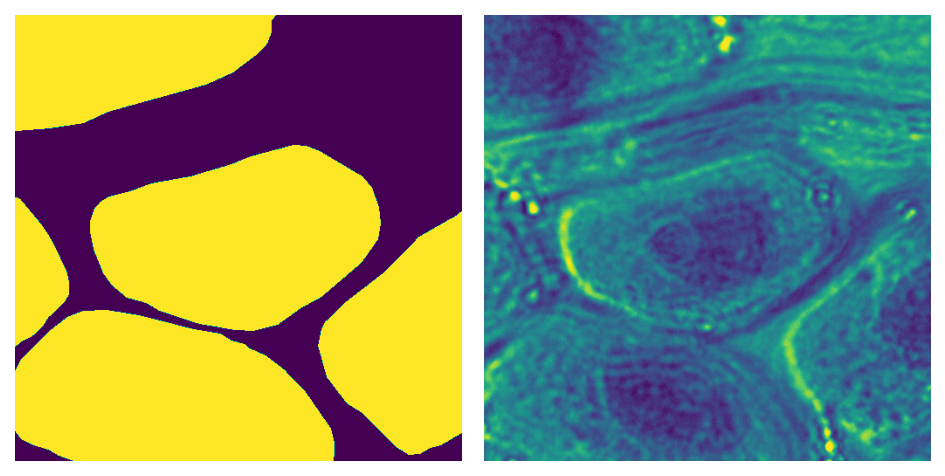

In [9]:
# Present an image from the cropped dataset

# Choose one
sample_show = 22 
# Get data 
cell_image_use = cell_images[sample_show]
cell_mask_use = cell_masks[sample_show]

# Plot
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(cell_mask_use)
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(cell_image_use)
plt.axis("off")
plt.tight_layout()
plt.show()
    
    

### Crop Dataset into Tiles

Here we take the raw dataset and generate a new dataset that is a simple windowed version of the original. 
The function will blindly crop the input, this is suefull to generate data for segmentation process testing when the input raw image is too large.

In [10]:
cut_list = data_augmentation.cut_image(image_changed, 256, 256, 128, 128)

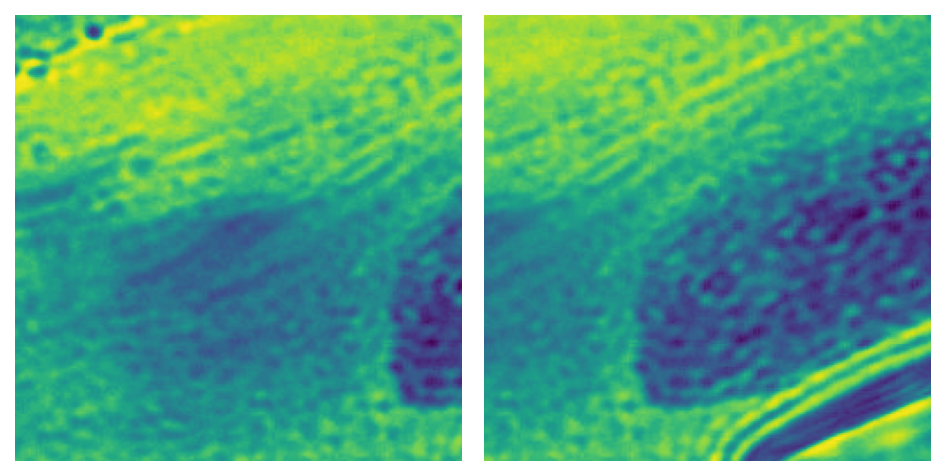

In [11]:
# Plot two consecutive tiles
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(cut_list[0])
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(cut_list[1])
plt.axis("off")
plt.tight_layout()
plt.show()

### Dataset Balancing

The created datasets will probably have unbalanced clases, this function aims to balance the data by discarding images with labels that are seen too often.

In [12]:
metadata_balanced = data_utils.metadata_balanced(metadata)

total by category :
	Interfase = 58
	Profase = 29
	Metafase = 11
	Anafase = 11
	Telofase = 32
	Desconocido = 47
updated total by category  :
	Interfase = 24
	Profase = 11
	Metafase = 11
	Anafase = 4
	Telofase = 14
	Desconocido = 19


In [13]:
# Using the generated metadata we can save a new balanced dataset
OUTPUT_FOLDER_BALANCED = os.path.dirname(OUTPUT_FOLDER)
(train_images, 
 train_target, 
 validation_images, 
 validation_target, 
 metadata_new) = data_utils.create_dataset(OUTPUT_FOLDER, "balanced_dataset", metadata_balanced, output_path=OUTPUT_FOLDER_BALANCED)

In [14]:
metadata_new.head()

,image,Fondo,Interfase,Profase,Metafase,Anafase,Telofase,Desconocido,split
0,333.png,True,True,False,False,True,True,True,Train
1,342.png,True,True,True,True,False,True,True,Train
2,343.png,True,True,True,False,False,False,False,Train
3,346.png,True,True,True,True,False,False,False,Train
4,350.png,True,True,False,True,False,False,True,Train
